## Section 1: Project & Objective

**Goal:** Use unsupervised ML to identify player roles in Europe's Top 5 Leagues (23/24), moving beyond traditional position labels.

## Section 2: Setup & Data Ingestion

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score , calinski_harabasz_score
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv('../../data/interim/player_season_stats_23-24_relevant.csv')
df.head(3)

,league,season,team,player,nation,pos,age,MP Playing Time,Min Playing Time,90s Playing Time,...,Won% Aerial Duels,Fls Performance,Fld Performance,Att Pen Touches,Att 3rd Touches,Mid 3rd Touches,Def 3rd Touches,Def Pen Touches,Live Touches,Cmp Total
0,ENG-Premier League,2324,Arsenal,Aaron Ramsdale,ENG,GK,25,6,540,6.0,...,NaN,0,1,0,0,11,186,140,197,131
1,ENG-Premier League,2324,Arsenal,Ben White,ENG,DF,25,37,2988,33.2,...,62.1,19,12,64,676,1165,633,120,2456,1828
2,ENG-Premier League,2324,Arsenal,Bukayo Saka,ENG,FW,21,35,2919,32.4,...,39.0,41,69,271,1310,474,182,37,1946,1143


#### Filter Players by Position

In [3]:
# Get Unique positions
unique_positions = df['pos'].unique()
print("Unique Positions:", unique_positions)

df_players = df[df['pos'] != 'GK']
print("Updated DataFrame shape (excluding GKs):", df_players['pos'].unique())

Unique Positions: ['GK' 'DF' 'FW' 'MF' 'MF,FW' 'FW,MF' 'MF,DF' 'DF,FW' 'FW,DF' 'DF,MF']
Updated DataFrame shape (excluding GKs): ['DF' 'FW' 'MF' 'MF,FW' 'FW,MF' 'MF,DF' 'DF,FW' 'FW,DF' 'DF,MF']


#### Remove Duplicated Players
Those players who played for more than one team in a season

In [4]:
# Identify duplicate players based on player name ('player')
duplicate_players = df_players[df_players.duplicated(subset=['player'], keep=False)]
print("Duplicate Players:\n", len(duplicate_players))

# Remove duplicate players, keeping the first appearance sorted by minutes played
df_players = df_players.sort_values('Min Playing Time', ascending=False)
df_players = df_players.drop_duplicates(subset=['player'], keep='first')
print("DataFrame shape after removing duplicates:", df_players.shape)

Duplicate Players:
 293
DataFrame shape after removing duplicates: (2502, 54)


#### Filter Players by Playing Time and Maches Played

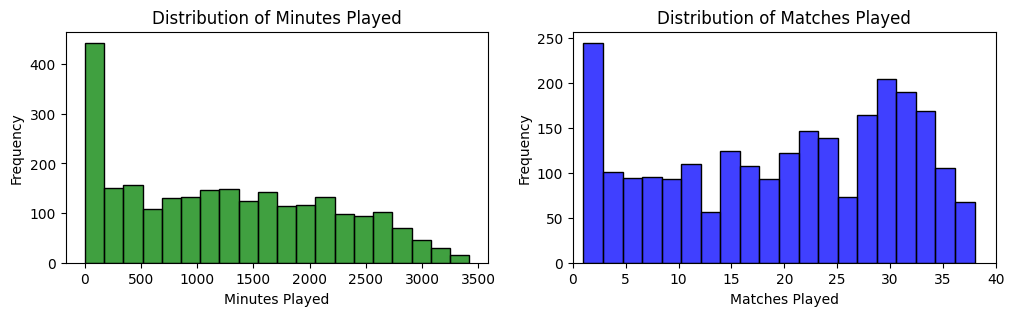

In [5]:
# Plot Distribution of Min Playing Time and MP Playing Time side by side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_players['Min Playing Time'],bins=20, color='green', kde=False)
plt.title('Distribution of Minutes Played')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df_players['MP Playing Time'],bins=20, color='blue', kde=False)
plt.xlim(0, 40)
plt.title('Distribution of Matches Played')
plt.xlabel('Matches Played')
plt.ylabel('Frequency')
plt.show()



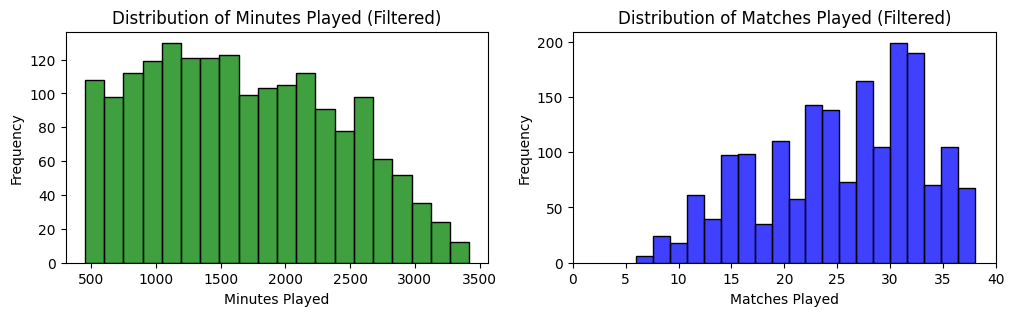

In [6]:
# Remove players with less than 450 minutes played and less than 5 matches played
df_players_filtered = df_players[(df_players['Min Playing Time'] >= 450) & (df_players['MP Playing Time'] >= 5)]

# Plot Distribution of Min Playing Time and MP Playing Time after filtering
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_players_filtered['Min Playing Time'], bins=20, color='green', kde=False)
plt.title('Distribution of Minutes Played (Filtered)')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df_players_filtered['MP Playing Time'], bins=20, color='blue', kde=False)
plt.title('Distribution of Matches Played (Filtered)')
plt.xlim(0, 40)
plt.xlabel('Matches Played')
plt.ylabel('Frequency')
plt.show()

### Handle NaN

In [7]:
# Find nan values in numeric_df
nan_counts = df_players_filtered.isna().sum()
print("NaN values in numeric DataFrame:\n", nan_counts[nan_counts > 0])

# Find if players with NaN values in one column have NaN values in other columns
nan_players = df_players_filtered[df_players_filtered.isna().any(axis=1)]
print("\nPlayers with NaN values:\n", len(nan_players))

NaN values in numeric DataFrame:
 nation                1
SoT% Standard        13
Dist Standard        13
G/Sh Standard        13
Succ% Take-Ons       22
Won% Aerial Duels     1
dtype: int64

Players with NaN values:
 37


In [8]:
# Remove rows with NaN values
df_players_filtered = df_players_filtered.dropna()
print("DataFrame shape after removing NaNs:", df_players_filtered.shape)

DataFrame shape after removing NaNs: (1765, 54)


## Section 3: Feature Engineering

In [9]:
columns_90 = ['npxG Per 90 Minutes',
            'G-PK Per 90 Minutes',
            'xAG Per 90 Minutes',
            'xG+xAG Per 90 Minutes',
            'Sh/90 Standard',
            'SoT% Standard',
            "Dist Standard",
            "G/Sh Standard",
            "Cmp% Total",
            "Cmp% Long",
            "Succ% Take-Ons",
            'Won% Aerial Duels',
            ]

columns_to_90s = ['KP',
                    'PrgP',
                    'PPA',
                    'CrsPA',
                    '1/3',
                    'Att Long',
                    'TB Pass Types',
                    'Sw Pass Types',
                    'Crs Pass Types',
                    'PrgC Carries',
                    'CPA Carries',
                    'Succ Take-Ons',
                    'Dis Carries',
                    'Mis Carries',
                    'PrgR Receiving',
                    'TklW Tackles',
                    'Att 3rd Tackles',
                    'Mid 3rd Tackles',
                    'Def 3rd Tackles',
                    'Int',
                    'Sh Blocks',
                    'Recov Performance',
                    'Won Aerial Duels',
                    'Fls Performance',
                    'Fld Performance',
                    'Att Pen Touches',
                    'Att 3rd Touches',
                    'Mid 3rd Touches',
                    'Def 3rd Touches',
                    'Def Pen Touches',
                    'Live Touches',
                    'Cmp Total'
                    ]

print("Number of features: ", len(columns_90) + len(columns_to_90s))

Number of features:  44


In [10]:
# Check missing columns
missing_columns = [col for col in df_players_filtered.columns if col not in columns_90 + columns_to_90s]
print("Missing columns:", missing_columns)
# Missing columns are those that are not in the selected features list

Missing columns: ['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'MP Playing Time', 'Min Playing Time', '90s Playing Time']


In [11]:
# Scale Performance Metrics by 90s (minutes played / 90)
df_players_scaled = df_players_filtered.copy()
df_players_scaled[columns_to_90s] = df_players_scaled[columns_to_90s].div(df_players_scaled['90s Playing Time'], axis=0).round(2)

In [12]:
# Prepare final dataset for clustering
# Drop metadata columns AND playing time columns (not relevant for our clustering approach)
droping_columns = ['league', 'team', 'player', 'nation', 'pos', 'season', 'age', 
                   'MP Playing Time', 'Min Playing Time', '90s Playing Time']
df_players_final = df_players_scaled.drop(columns=droping_columns)

print(f"Final dataset: {df_players_final.shape[0]} players ; {df_players_final.shape[1]} features")
print(f"Features for clustering: {df_players_final.columns.tolist()}")

Final dataset: 1765 players ; 44 features
Features for clustering: ['npxG Per 90 Minutes', 'G-PK Per 90 Minutes', 'xAG Per 90 Minutes', 'xG+xAG Per 90 Minutes', 'Sh/90 Standard', 'SoT% Standard', 'Dist Standard', 'G/Sh Standard', 'KP', 'PrgP', 'PPA', 'CrsPA', '1/3', 'Cmp% Total', 'Cmp% Long', 'Att Long', 'TB Pass Types', 'Sw Pass Types', 'Crs Pass Types', 'PrgC Carries', 'CPA Carries', 'Succ Take-Ons', 'Succ% Take-Ons', 'Dis Carries', 'Mis Carries', 'PrgR Receiving', 'TklW Tackles', 'Att 3rd Tackles', 'Mid 3rd Tackles', 'Def 3rd Tackles', 'Int', 'Sh Blocks', 'Recov Performance', 'Won Aerial Duels', 'Won% Aerial Duels', 'Fls Performance', 'Fld Performance', 'Att Pen Touches', 'Att 3rd Touches', 'Mid 3rd Touches', 'Def 3rd Touches', 'Def Pen Touches', 'Live Touches', 'Cmp Total']


In [13]:
# Quick check on numeric_df
df_players_final.head(3)

,npxG Per 90 Minutes,G-PK Per 90 Minutes,xAG Per 90 Minutes,xG+xAG Per 90 Minutes,Sh/90 Standard,SoT% Standard,Dist Standard,G/Sh Standard,KP,PrgP,...,Won% Aerial Duels,Fls Performance,Fld Performance,Att Pen Touches,Att 3rd Touches,Mid 3rd Touches,Def 3rd Touches,Def Pen Touches,Live Touches,Cmp Total
24,0.04,0.05,0.01,0.05,0.26,30.0,10.5,0.20,0.16,4.13,...,59.5,0.58,0.42,0.39,3.74,45.26,32.61,5.87,81.39,69.34
569,0.05,0.05,0.04,0.08,0.37,35.7,9.8,0.14,0.45,3.08,...,70.5,1.00,0.47,0.79,3.50,29.21,38.89,11.87,71.21,52.08
246,0.07,0.03,0.06,0.13,0.66,16.0,9.9,0.04,0.58,3.42,...,69.7,1.18,0.66,2.21,4.71,22.32,26.32,9.26,53.00,31.45


### Feature Correlations

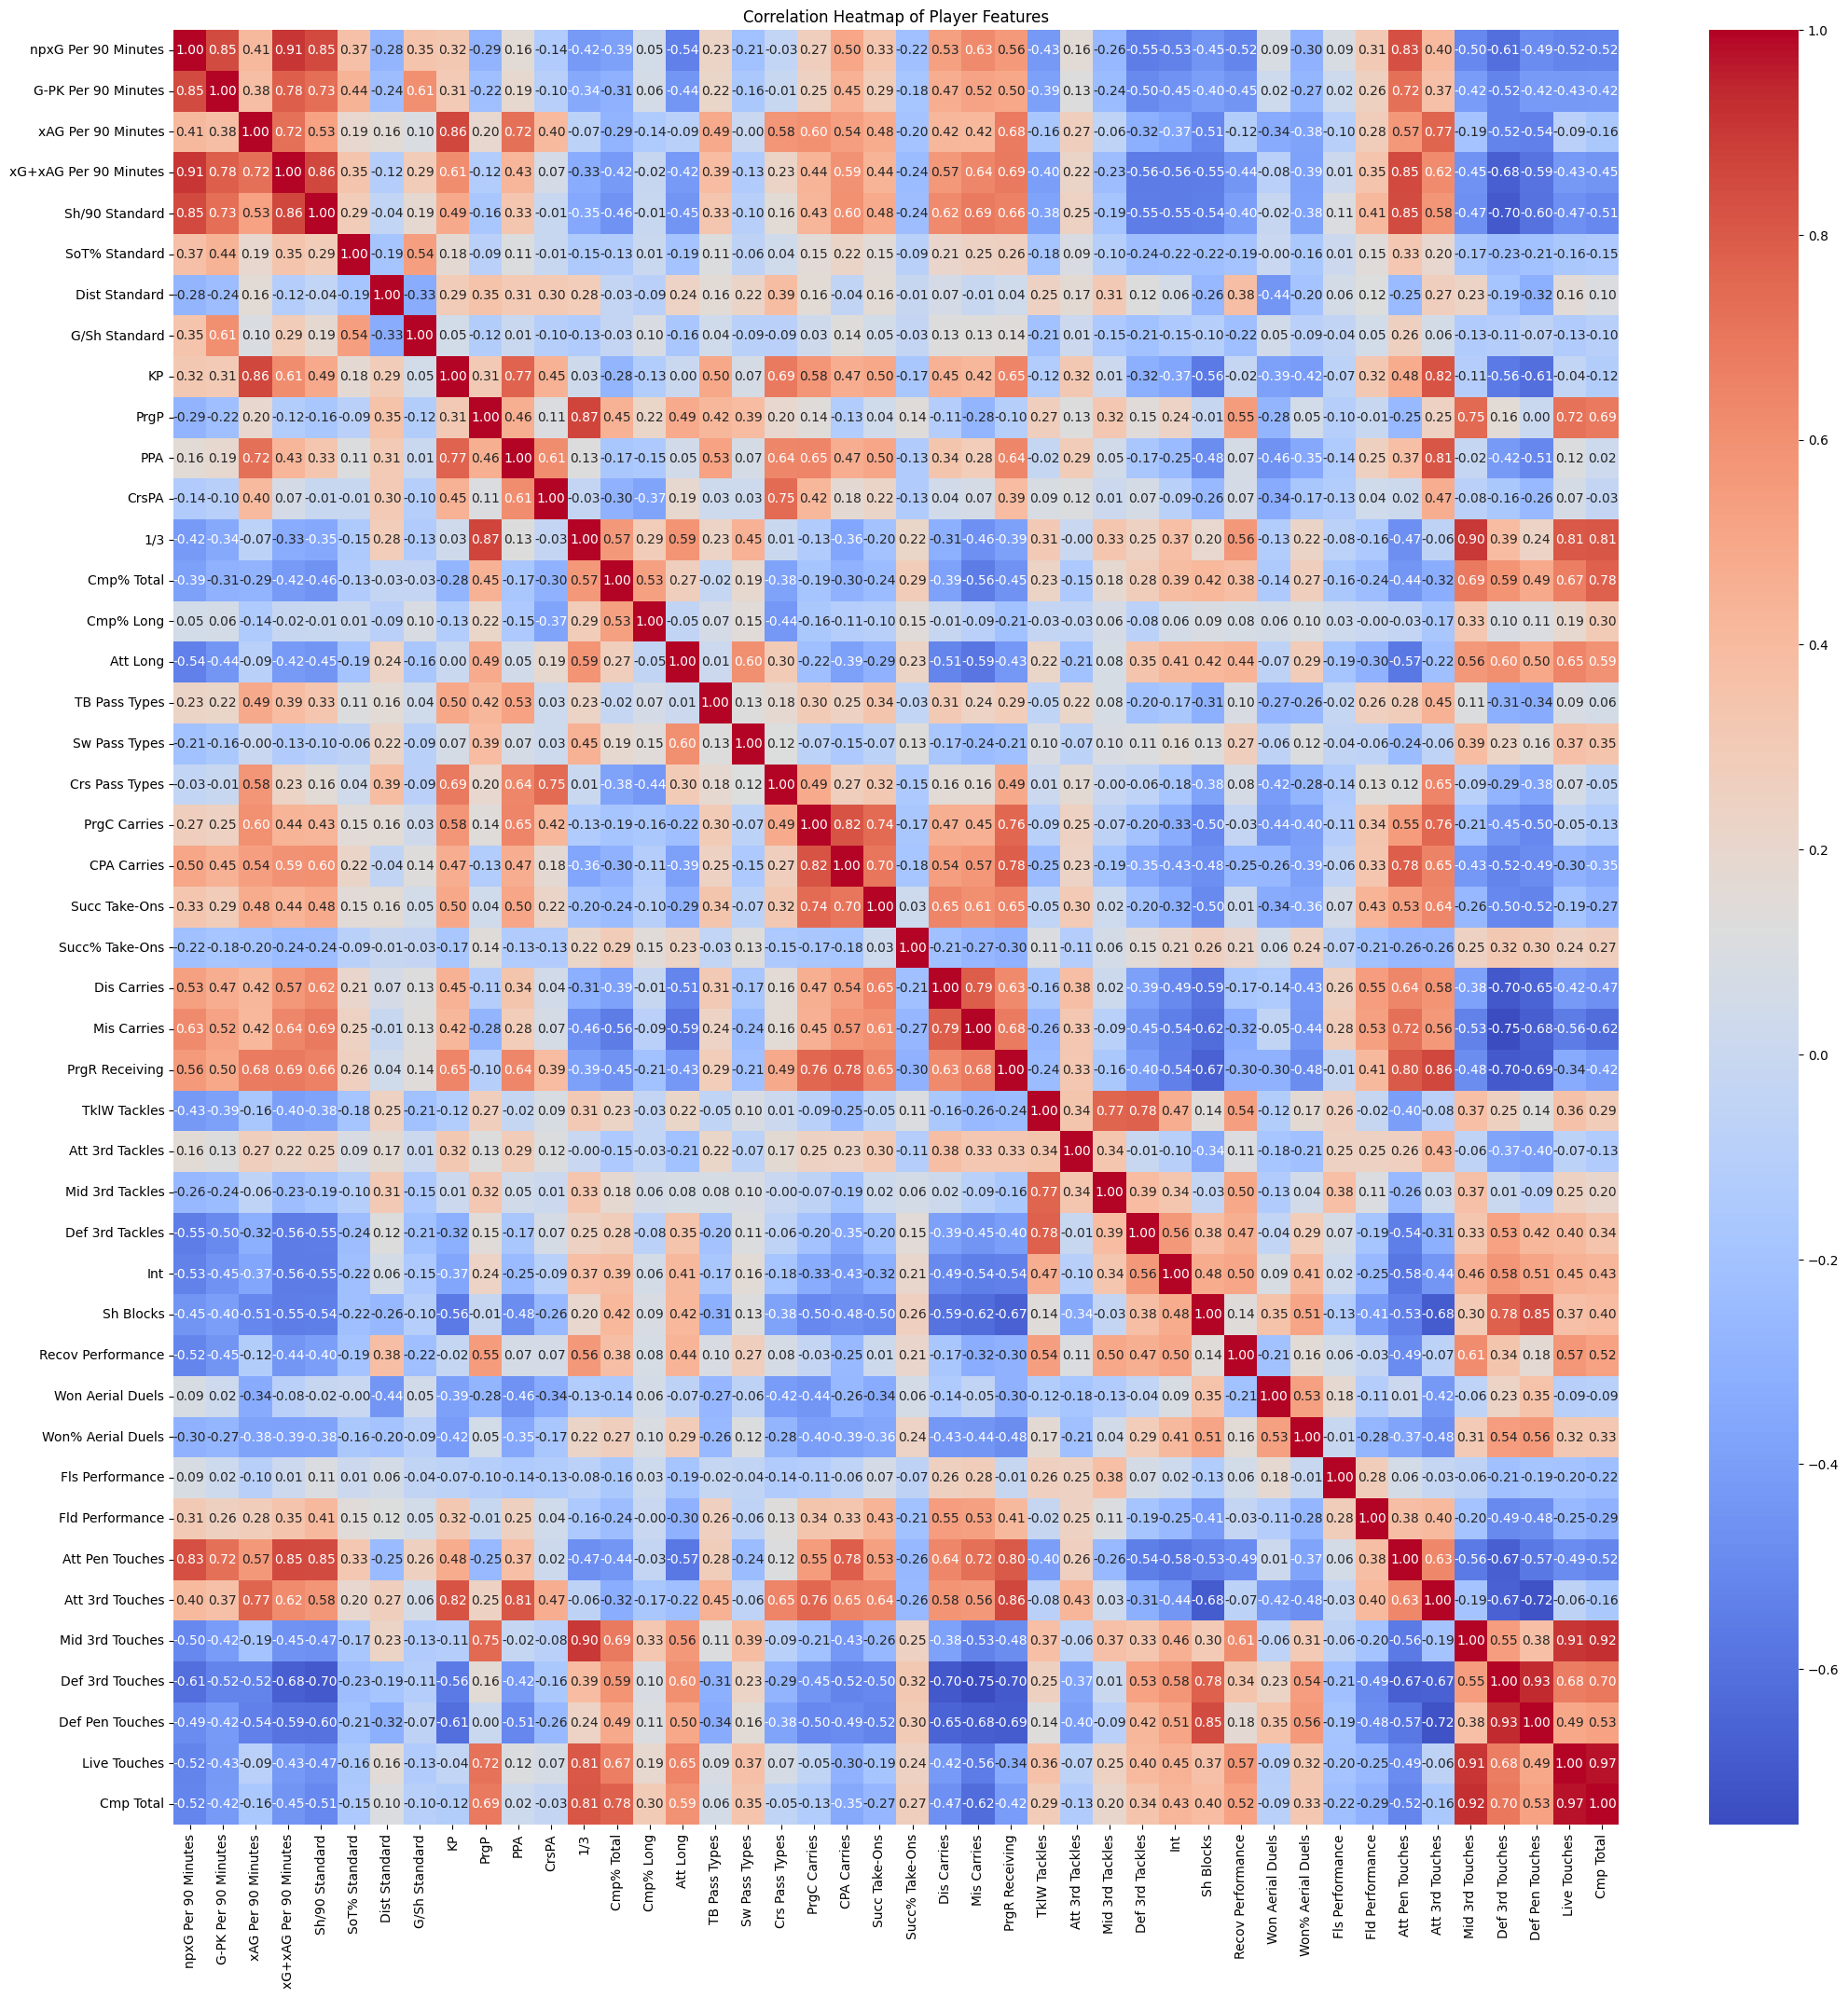

In [14]:
# Plot Correlation Heatmap
plt.figure(figsize=(25, 25))                    
sns.heatmap(df_players_final.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Player Features')
plt.show()

In [15]:
def identify_collinear_features(df, threshold=0.90):
    # Identify features that are highly correlated (above threshold).
        
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    for col in to_drop:
        # Find the feature it is correlated with
        correlated_with = upper.index[upper[col] > threshold].tolist()
        
        for partner in correlated_with:
            print(f"Conflict: {col} vs {partner}.")


identify_collinear_features(df_players_final, threshold=0.85)


Conflict: xG+xAG Per 90 Minutes vs npxG Per 90 Minutes.
Conflict: Sh/90 Standard vs npxG Per 90 Minutes.
Conflict: Sh/90 Standard vs xG+xAG Per 90 Minutes.
Conflict: KP vs xAG Per 90 Minutes.
Conflict: 1/3 vs PrgP.
Conflict: Att 3rd Touches vs PrgR Receiving.
Conflict: Mid 3rd Touches vs 1/3.
Conflict: Def Pen Touches vs Def 3rd Touches.
Conflict: Live Touches vs Mid 3rd Touches.
Conflict: Cmp Total vs Mid 3rd Touches.
Conflict: Cmp Total vs Live Touches.


In [16]:
columns_to_drop_from_corr = [
    # Attack Redundancies
    'xG+xAG Per 90 Minutes',  # We kept npxG and xAG separately
    'Sh/90 Standard',         # We kept npxG (Quality over Quantity)
    
    # Playmaking Redundancies
    'KP',                     # We kept xAG (Quality over Quantity)
    
    # Progression Redundancies
    '1/3',                    # We kept PrgP (Intent) and Mid 3rd (Location)
    'Att 3rd Touches',        # We kept PrgR (Role) and Att Pen Touches (Location)
    
    # Defensive/Volume Redundancies
    'Def 3rd Touches',        # We kept Def Pen Touches (Specific to CBs)
    'Live Touches',           # Pure volume metric (biased by team possession)
    'Cmp Total'               # Pure volume metric
]
df_players_final = df_players_final.drop(columns=columns_to_drop_from_corr)
print(f"Dataset shape after dropping collinear features: {df_players_final.shape}")

Dataset shape after dropping collinear features: (1765, 36)


### PCA

In [17]:
# Standardize the data
scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(df_players_final)   

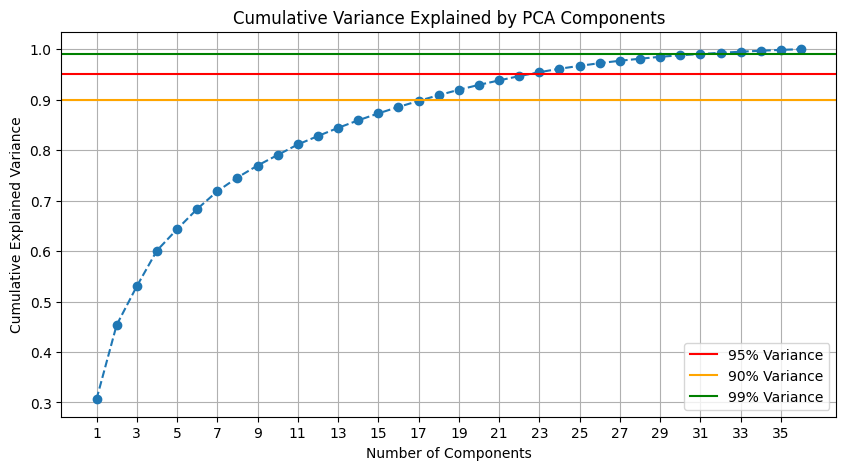

Number of components for 90% variance: 18
Number of components for 95% variance: 23
Number of components for 99% variance: 31


In [18]:
def cumulative_variance_pca(numeric_df_scaled):
    # Perform PCA for dimensionality reduction
    pca = PCA()
    pca_transformed = pca.fit_transform(numeric_df_scaled)

    # Calculate cumulative variance explained
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative variance explained
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Variance Explained by PCA Components')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance')
    plt.axhline(y=0.90, color='orange', linestyle='-', label='90% Variance')
    plt.axhline(y=0.99, color='green', linestyle='-', label='99% Variance')
    plt.xticks(range(1, len(cumulative_variance) + 1, 2))
    plt.legend()
    plt.show()

    print(f"Number of components for 90% variance: {np.argmax(cumulative_variance >= 0.90) + 1}")
    print(f"Number of components for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
    print(f"Number of components for 99% variance: {np.argmax(cumulative_variance >= 0.99) + 1}")

    return pca, pca_transformed, cumulative_variance
pca, pca_transformed, cumulative_variance= cumulative_variance_pca(numeric_df_scaled)

In [19]:
# Get the number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# Get the feature loadings (components) for those principal components
components_90 = pca.components_[:n_components_90]
# Get feature names
feature_names = df_players_final.columns.tolist()

# For each principal component, show the top contributing features
for i in range(5): #n_components_90
    # Get absolute loadings for this component
    loadings = np.abs(components_90[i])
    
    # Get indices of top 5 features
    top_indices = np.argsort(loadings)[-5:][::-1]
    
    print(f"\nPrincipal Component {i+1} (explains {pca.explained_variance_ratio_[i]:.2%} variance):")
    print("Top 5 contributing features:")
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {components_90[i, idx]:.3f}")


Principal Component 1 (explains 30.65% variance):
Top 5 contributing features:
  PrgR Receiving: 0.269
  Att Pen Touches: 0.263
  Mis Carries: 0.249
  Def Pen Touches: -0.241
  CPA Carries: 0.233

Principal Component 2 (explains 14.71% variance):
Top 5 contributing features:
  PrgP: 0.302
  Dist Standard: 0.288
  PPA: 0.279
  Recov Performance: 0.273
  Crs Pass Types: 0.262

Principal Component 3 (explains 7.66% variance):
Top 5 contributing features:
  Fls Performance: 0.393
  Mid 3rd Tackles: 0.381
  TklW Tackles: 0.307
  Crs Pass Types: -0.281
  Att 3rd Tackles: 0.273

Principal Component 4 (explains 7.08% variance):
Top 5 contributing features:
  Cmp% Long: 0.391
  Cmp% Total: 0.351
  PrgP: 0.321
  Mid 3rd Touches: 0.283
  TB Pass Types: 0.278

Principal Component 5 (explains 4.22% variance):
Top 5 contributing features:
  G/Sh Standard: 0.429
  SoT% Standard: 0.373
  Dist Standard: -0.301
  Def 3rd Tackles: 0.300
  TklW Tackles: 0.286


In [20]:
# Work with first n_components_90 principal components
pca_final = PCA(n_components=n_components_90)
pca_final_transformed = pca_final.fit_transform(numeric_df_scaled)


### Clustering Methods

#### K-Means

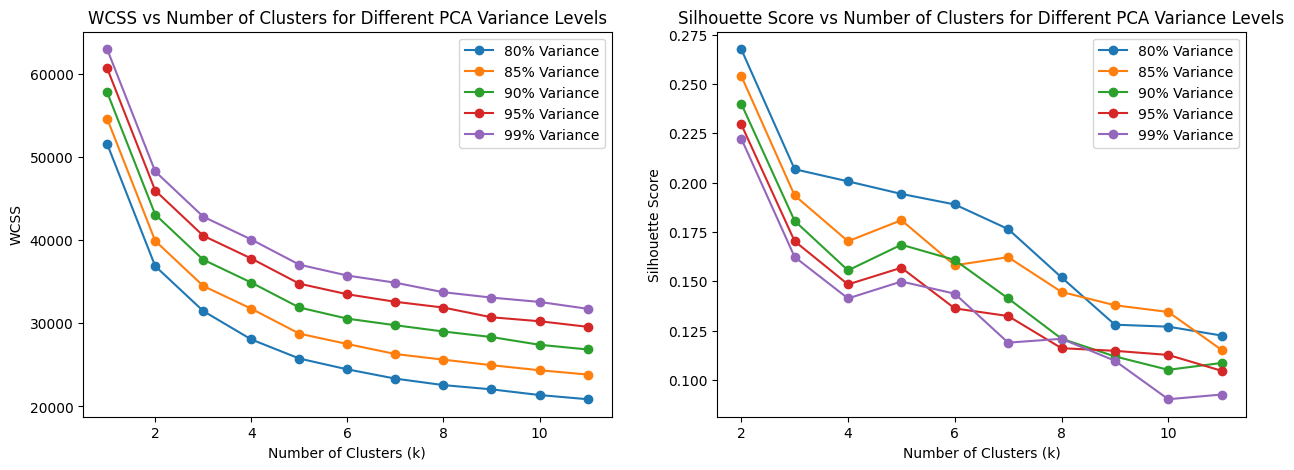

In [21]:
percentiles = [80,85,90,95,99]
wcss = []
silhouette_scores = []
for perc in percentiles:
    n_componnet = np.argmax(cumulative_variance >= perc/100) + 1
    pca_data = PCA(n_components=n_componnet).fit_transform(numeric_df_scaled)
    wcss_perc = []
    silhouette_scores_perc = []
    for k in range(1,12):
        kmean = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmean.fit(pca_data)
        wcss_perc.append(kmean.inertia_)
        if k > 1:
            labels = k
            silhouette_avg = silhouette_score(pca_data, kmean.labels_)
            silhouette_scores_perc.append(silhouette_avg)
    wcss.append(wcss_perc)
    silhouette_scores.append(silhouette_scores_perc)

# Subplot side by side  WCSS and silhouette scores for different percentiles and k values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i, perc in enumerate(percentiles):
    plt.plot(range(1, 12), wcss[i], marker='o', label=f'{perc}% Variance')
plt.title('WCSS vs Number of Clusters for Different PCA Variance Levels')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.legend()
plt.subplot(1, 2, 2)
for i, perc in enumerate(percentiles):
    plt.plot(range(2, 12), silhouette_scores[i], marker='o', label=f'{perc}% Variance')
plt.title('Silhouette Score vs Number of Clusters for Different PCA Variance Levels')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

#### DBASCAN

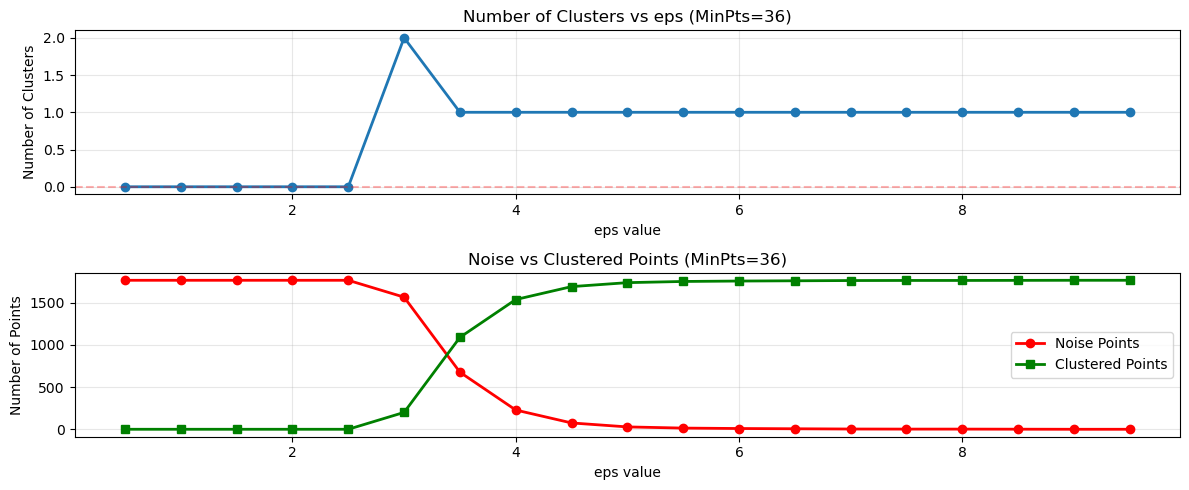

In [52]:
# Test different eps values and track number of clusters
eps_values = np.arange(0.5, 10, 0.5)
n_clusters_list = []
n_noise_list = []
cluster_info = []
minPts = n_components_90*2

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(pca_final_transformed)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    n_clusters_list.append(n_clusters)
    n_noise_list.append(n_noise)
    cluster_info.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'n_clustered': len(labels) - n_noise
    })

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Plot 1: Number of clusters vs eps
axes[0].plot(eps_values, n_clusters_list, marker='o', linewidth=2, markersize=6)
axes[0].set_xlabel('eps value')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title(f'Number of Clusters vs eps (MinPts={minPts})')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Plot 2: Number of noise points and clustered points vs eps
axes[1].plot(eps_values, n_noise_list, marker='o', linewidth=2, markersize=6, label='Noise Points', color='red')
axes[1].plot(eps_values, [len(pca_final_transformed) - n for n in n_noise_list], 
             marker='s', linewidth=2, markersize=6, label='Clustered Points', color='green')
axes[1].set_xlabel('eps value')
axes[1].set_ylabel('Number of Points')
axes[1].set_title(f'Noise vs Clustered Points (MinPts={minPts})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### DBSCAN Parameter Grid Search

In [22]:
percentiles = [80,85,90,95,99]
eps_values = np.arange(0.5, 10, 0.5)

global_cluster_list = []
global_noise_info = []
global_clustered_info = []
components_list = []
best_results = []
for p in percentiles:
    # Get the number of components for the given percentile
    n_componnet = np.argmax(cumulative_variance >= p/100) + 1
    components_list.append(n_componnet)
    pca_data = PCA(n_components=n_componnet).fit_transform(numeric_df_scaled)
    
    # Calculate MinPts range
    minPts = np.arange(6, 2*n_componnet, 2)
    
    # Nested lists
    eps_cluster_list = []
    eps_noise_info = []
    eps_clustered_info = []
    for minPts_val in minPts:
        # Nested lists
        n_clusters_list = []
        n_noise_list = []
        n_cluster_info = []
        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=minPts_val)
            labels = dbscan.fit_predict(pca_data)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Calculate Silhoutte score
            
            n_clusters_list.append(n_clusters)
            n_noise_list.append(n_noise)
            n_cluster_info.append({
                'eps': eps,
                'minPts': minPts_val,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'n_clustered': len(labels) - n_noise
            })
        eps_cluster_list.append(n_clusters_list)
        eps_noise_info.append(n_noise_list)
        eps_clustered_info.append(n_cluster_info)
        
    global_cluster_list.append(eps_cluster_list)
    global_noise_info.append(eps_noise_info)
    global_clustered_info.append(eps_clustered_info)
        
# Now global_cluster_list, global_noise_info, and global_clustered_info
# contain the clustering results for each percentile, eps, and minPts combination


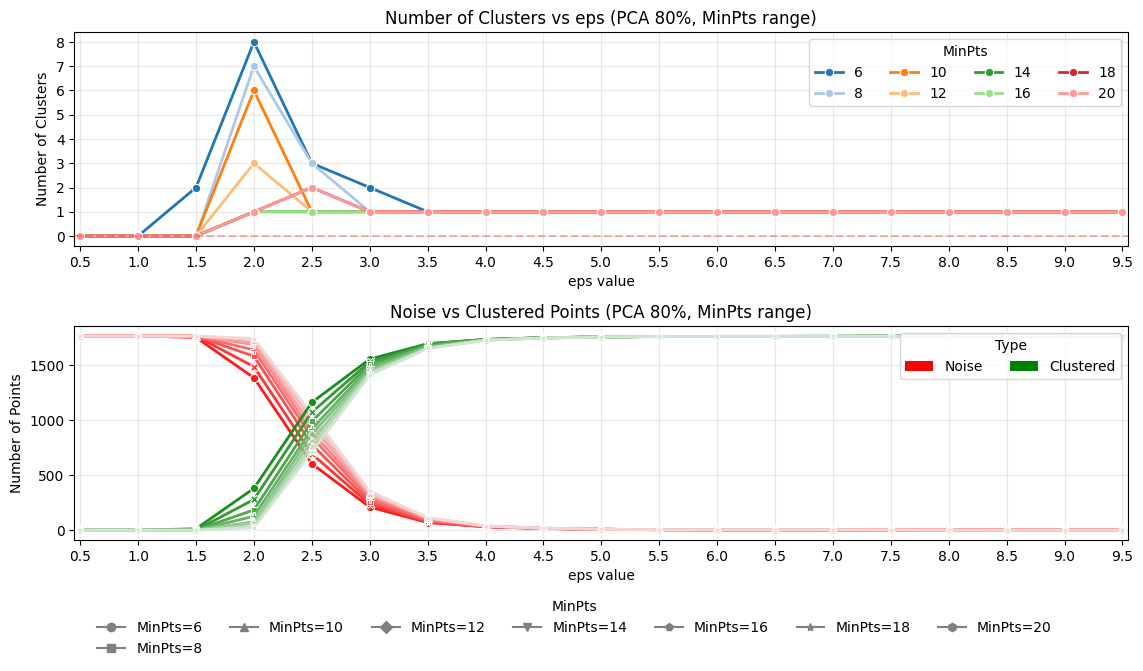

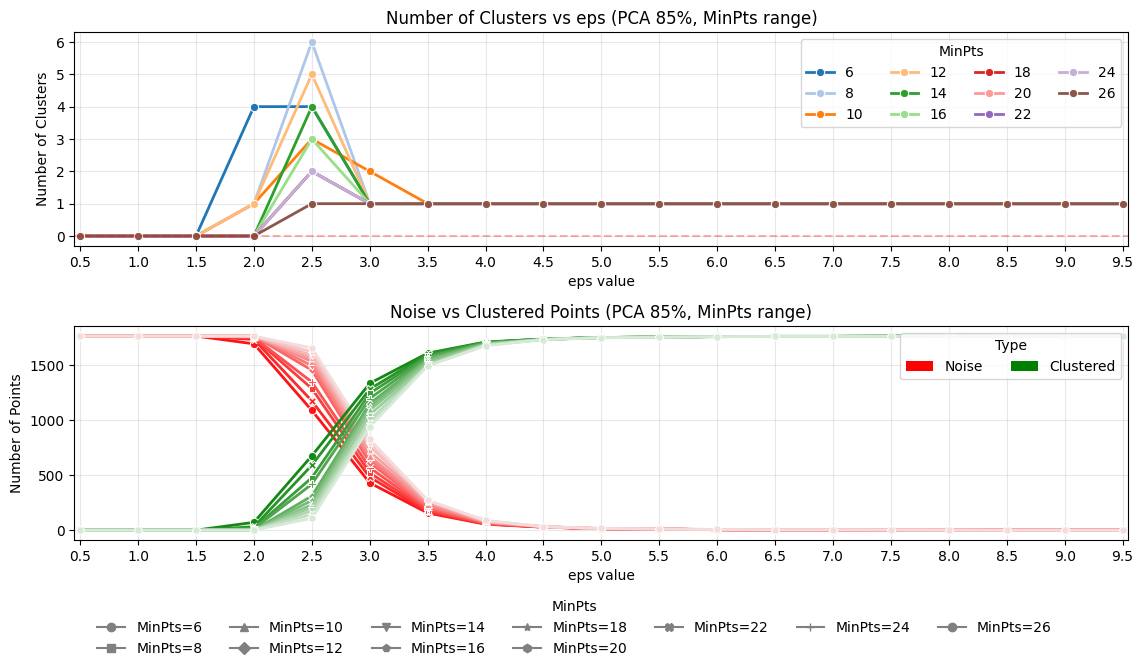

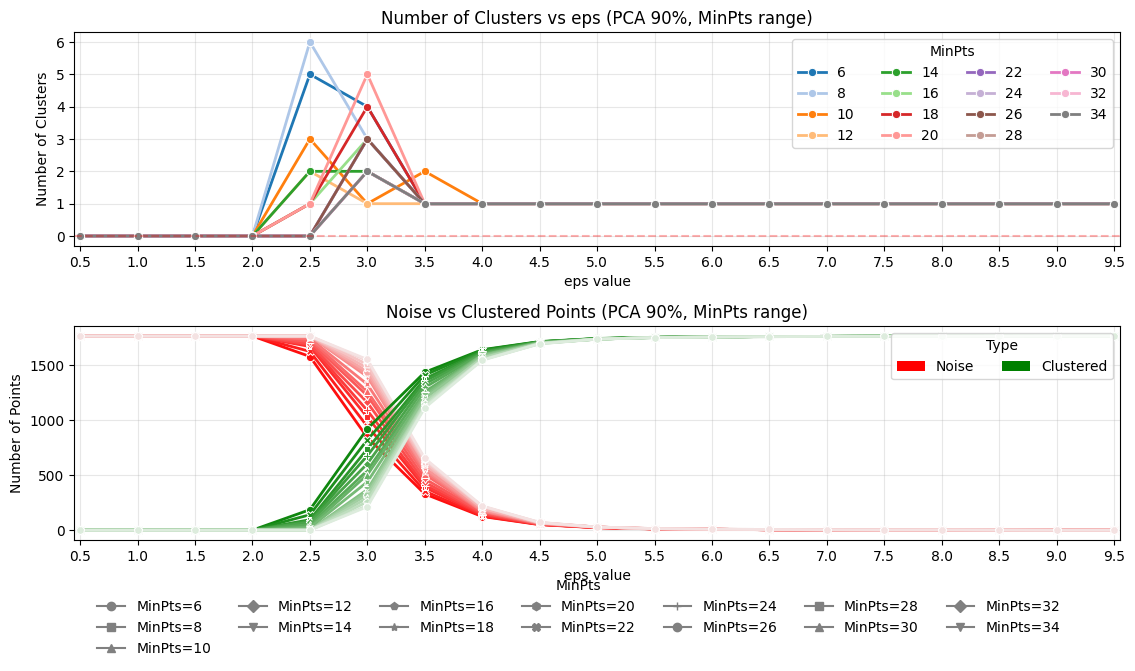

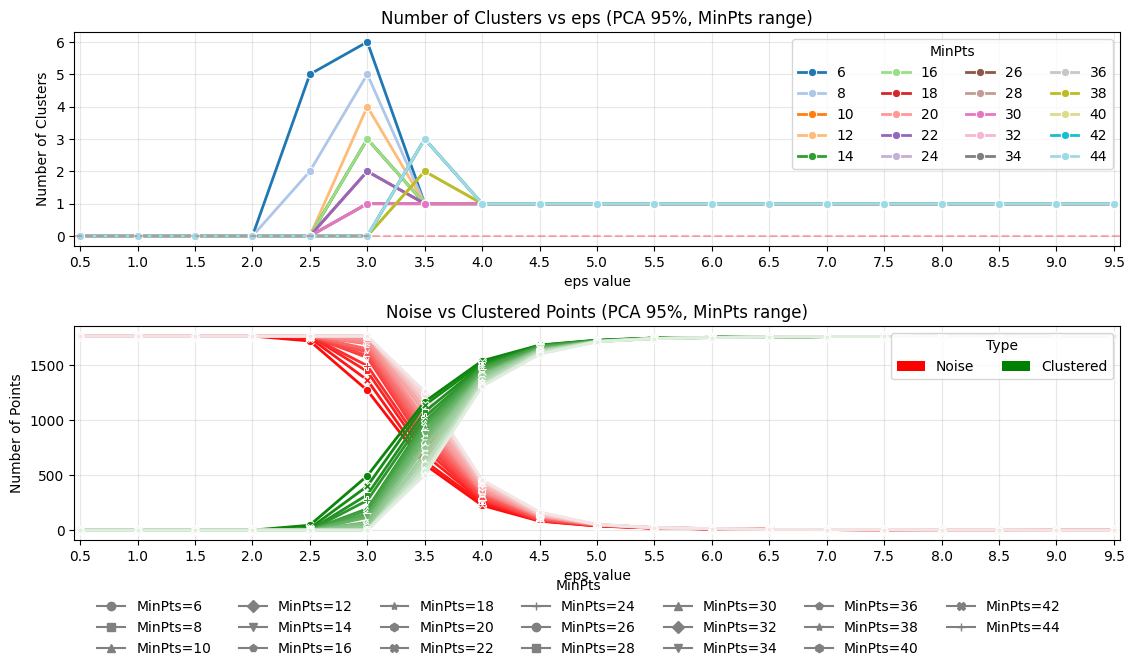

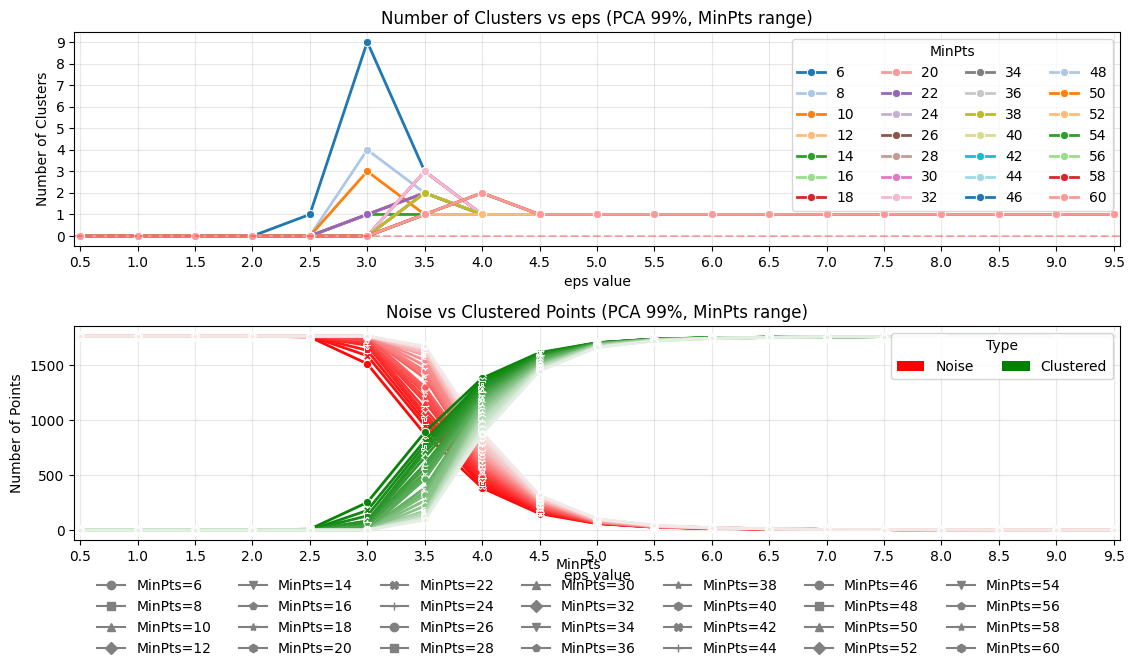

In [24]:
# Plot Results for each percentile using Seaborn
total_points = len(pca_data)

for i, p in enumerate(percentiles):
    # Prepare data for seaborn
    plot_data = []
    
    for j, minPts_val in enumerate(range(6, 2*components_list[i], 2)):
        for k, eps in enumerate(eps_values):
            plot_data.append({
                'eps': eps,
                'MinPts': minPts_val,
                'n_clusters': global_cluster_list[i][j][k],
                'noise': global_noise_info[i][j][k],
                'clustered': total_points - global_noise_info[i][j][k]
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 7))
    
    # Subplot 1 - Number of clusters vs eps
    sns.lineplot(data=df_plot, x='eps', y='n_clusters', hue='MinPts', 
                 marker='o', linewidth=2, markersize=6, palette='tab20', ax=axes[0])
    axes[0].set_xlabel('eps value')
    axes[0].set_xticks(eps_values)
    axes[0].set_xlim(eps_values[0]-0.05, eps_values[-1]+0.05)
    axes[0].set_ylabel('Number of Clusters')
    axes[0].set_yticks(range(0, df_plot['n_clusters'].max()+1))
    axes[0].set_title(f'Number of Clusters vs eps (PCA {p}%, MinPts range)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[0].legend(title='MinPts',loc='upper right', ncol=4)
    
    # Subplot 2 - Noise and clustered points vs eps
    df_long = pd.melt(df_plot, id_vars=['eps', 'MinPts'], 
                      value_vars=['noise', 'clustered'],
                      var_name='point_type', value_name='count')
    
    # Generate shades of red for noise and green for clustered
    minpts_unique = sorted(df_long['MinPts'].unique())
    n_minpts = len(minpts_unique)
    noise_palette = sns.light_palette("red", n_colors=n_minpts+2, reverse=True)[1:-1]
    clustered_palette = sns.light_palette("green", n_colors=n_minpts+2, reverse=True)[1:-1]
    
    # Create combined palette
    combined_palette = {}
    for idx, minpts in enumerate(minpts_unique):
        combined_palette[f'noise_{minpts}'] = noise_palette[idx]
        combined_palette[f'clustered_{minpts}'] = clustered_palette[idx]
    
    # Create combined hue column
    df_long['hue_combined'] = df_long['point_type'] + '_' + df_long['MinPts'].astype(str)
    
    # Convert MinPts to string for style mapping
    df_long['MinPts_str'] = df_long['MinPts'].astype(str)
    
    sns.lineplot(data=df_long, x='eps', y='count', hue='hue_combined', style='MinPts_str',
                 markers=True, dashes=False, linewidth=2, markersize=6, 
                 palette=combined_palette, ax=axes[1], legend=False)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # Color legend (point types)
    color_elements = [
        Patch(facecolor='red', label='Noise'),
        Patch(facecolor='green', label='Clustered')
    ]
    
    # Marker legend (MinPts values) - get actual markers used by seaborn
    marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', '+']
    marker_elements = [
        Line2D([0], [0], color='gray', marker=marker_styles[i % len(marker_styles)], 
               linestyle='-', markersize=6, label=f'MinPts={minpts}')
        for i, minpts in enumerate(minpts_unique)
    ]
    
    axes[1].set_xlabel('eps value')
    axes[1].set_xticks(eps_values)
    axes[1].set_xlim(eps_values[0]-0.05, eps_values[-1]+0.05)
    axes[1].set_ylabel('Number of Points')
    axes[1].set_title(f'Noise vs Clustered Points (PCA {p}%, MinPts range)')
    axes[1].grid(True, alpha=0.3)
    
    # Add two separate legends
    first_legend = axes[1].legend(handles=color_elements, title='Type', 
                                   loc='upper right', ncol=2, frameon=True)
    axes[1].add_artist(first_legend)
    axes[1].legend(handles=marker_elements, title='MinPts',
                   loc='lower left', bbox_to_anchor=(0.01, -0.6), ncol=7, frameon=False)
    
    plt.tight_layout()
    plt.show()

#### GMM (Gaussian Mixture Model) - Parametric Grid Search

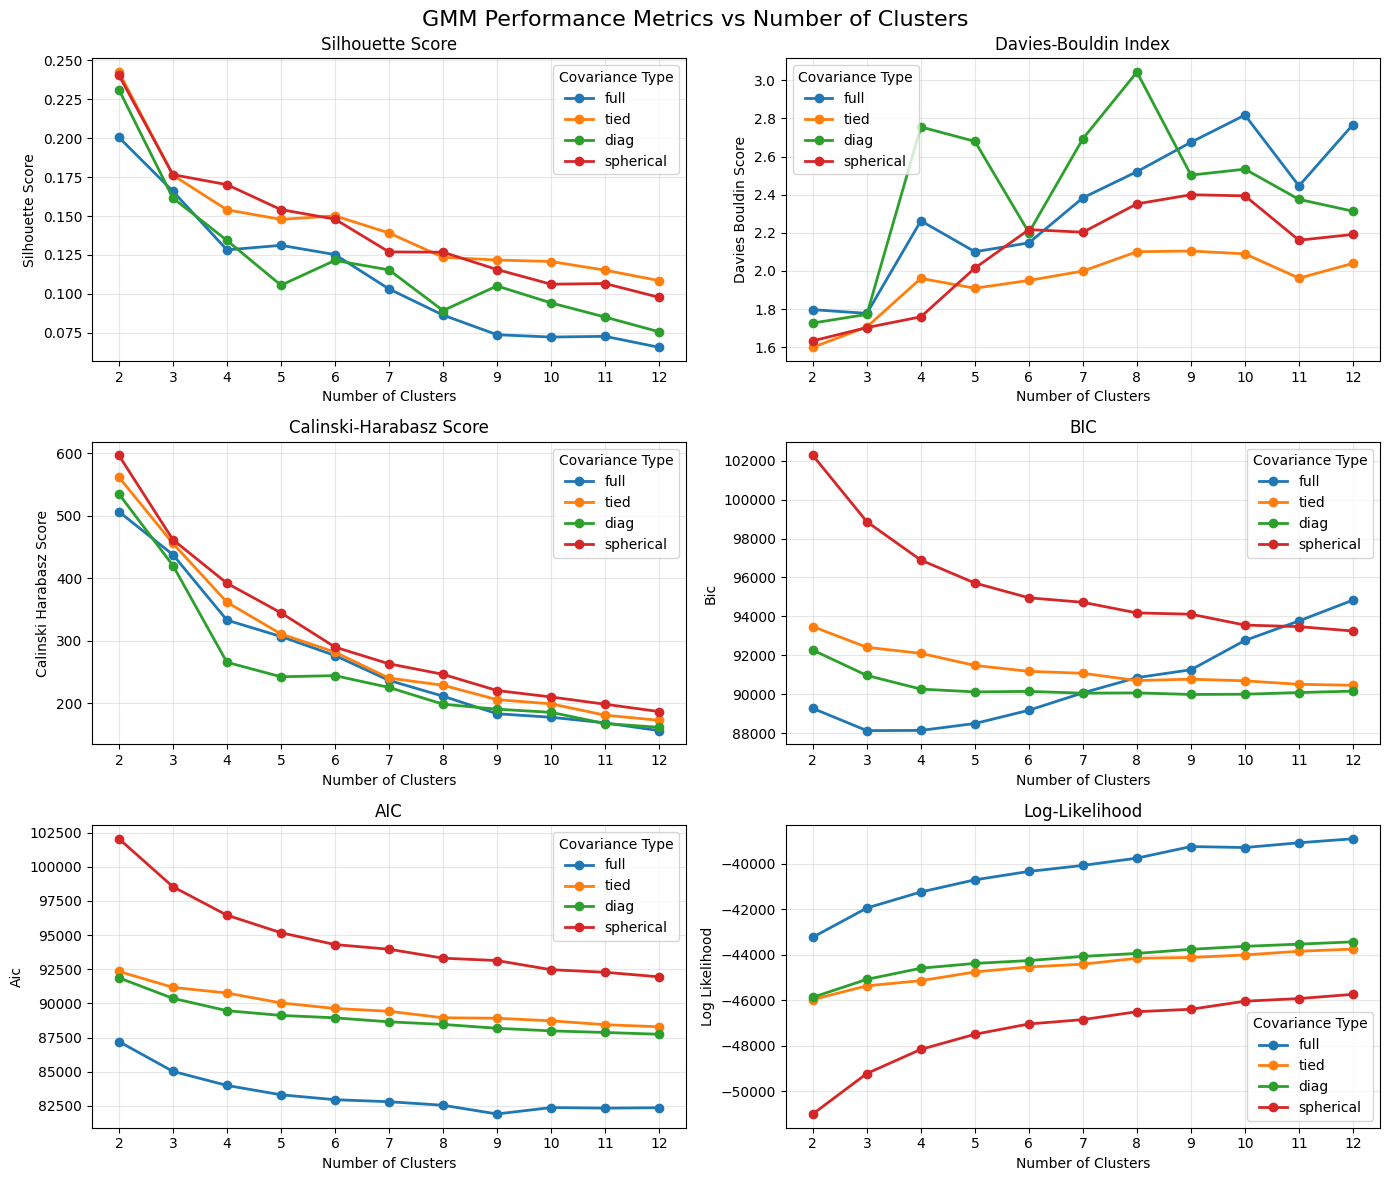

Best Silhouette Score: 
n_clusters                            2
covariance_type                    tied
silhouette_score               0.242481
davies_bouldin_score           1.599326
calinski_harabasz_score      562.053425
bic                        93475.618395
aic                        92336.629954
log_likelihood            -45960.314977
Name: 1, dtype: object

Best Davies-Bouldin Index (lowest): 
n_clusters                            2
covariance_type                    tied
silhouette_score               0.242481
davies_bouldin_score           1.599326
calinski_harabasz_score      562.053425
bic                        93475.618395
aic                        92336.629954
log_likelihood            -45960.314977
Name: 1, dtype: object

Best BIC (lowest): 
n_clusters                            3
covariance_type                    full
silhouette_score               0.165931
davies_bouldin_score           1.777352
calinski_harabasz_score      437.736266
bic                        8813

In [32]:
# Prepare data
pca_final = PCA(n_components=n_components_90)
pca_final_transformed = pca_final.fit_transform(numeric_df_scaled)
X = pca_final_transformed

# Define parameters
covariance_types = ['full', 'tied', 'diag', 'spherical']
n_clusters_range = range(2, 13)  # 2 to 12 clusters

# Store results
gmm_results = []

# Run GMM for different cluster numbers and covariance types
for n_clusters in n_clusters_range:
    for cov_type in covariance_types:
        # Fit GMM
        gmm_model = GaussianMixture(n_components=n_clusters, covariance_type=cov_type, random_state=42)
        gmm_model.fit(X)
        labels = gmm_model.predict(X)
        
        # Calculate metrics
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        bic = gmm_model.bic(X)
        aic = gmm_model.aic(X)
        log_likelihood = gmm_model.score(X) * len(X)  # Total log-likelihood
        
        # Store results
        gmm_results.append({
            'n_clusters': n_clusters,
            'covariance_type': cov_type,
            'silhouette_score': silhouette,
            'davies_bouldin_score': davies_bouldin,
            'calinski_harabasz_score': calinski_harabasz,
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood
        })

# Convert to DataFrame
gmm_results_df = pd.DataFrame(gmm_results)

# Plot metrics
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('GMM Performance Metrics vs Number of Clusters', fontsize=16)

metrics = [
    ('silhouette_score', 'Silhouette Score'),
    ('davies_bouldin_score', 'Davies-Bouldin Index'),
    ('calinski_harabasz_score', 'Calinski-Harabasz Score'),
    ('bic', 'BIC'),
    ('aic', 'AIC'),
    ('log_likelihood', 'Log-Likelihood')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for cov_type in covariance_types:
        data = gmm_results_df[gmm_results_df['covariance_type'] == cov_type]
        ax.plot(data['n_clusters'], data[metric], marker='o', label=cov_type, linewidth=2)
    
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title)
    ax.set_xticks(n_clusters_range)
    ax.grid(True, alpha=0.3)
    ax.legend(title='Covariance Type')

plt.tight_layout()
plt.show()

# Print best configurations
print(f"Best Silhouette Score: \n{gmm_results_df.loc[gmm_results_df['silhouette_score'].idxmax()]}")
print(f"\nBest Davies-Bouldin Index (lowest): \n{gmm_results_df.loc[gmm_results_df['davies_bouldin_score'].idxmin()]}")
print(f"\nBest BIC (lowest): \n{gmm_results_df.loc[gmm_results_df['bic'].idxmin()]}")
print(f"\nBest AIC (lowest): \n{gmm_results_df.loc[gmm_results_df['aic'].idxmin()]}")

In [ ]:
metrics = [
    ('silhouette_score', 'Silhouette Score (higher is better)'),
    ('davies_bouldin_score', 'Davies-Bouldin Index (lower is better)'),
    ('calinski_harabasz_score', 'Calinski-Harabasz Score (higher is better)'),
    ('bic', 'BIC (lower is better)'),
    ('aic', 'AIC (lower is better)'),
    ('log_likelihood', 'Log-Likelihood (higher is better)')
]